# Visualize Player Tracking and Events

Pascale Walters, May 27, 2022

## Step 1: Get matching powerplay event and tracking data 

We're going to use what we found in the [previous tutorial](join_tracking_pbp.ipynb) as the data source for one powerplay.

In [1]:
import pandas as pd

In [2]:
# Get player tracking data
pp_tracking = pd.read_csv('2022-02-08 Canada at USA/2022-02-08 Canada at USA P1 PP1.csv')
pp_tracking.head()

,frame_id,period,track_id,team_id,team_name,jersey_number,x_ft,y_ft
0,301,1,1,Light,Canada,6,171.071705,46.072340
1,301,1,2,Dark,USA,2,194.278571,41.647639
2,301,1,3,Dark,USA,37,194.258524,47.182641
3,301,1,4,Light,Canada,11,202.732672,67.352362
4,301,1,5,Dark,USA,28,174.116300,38.757970


In [3]:
# Get matching event data
play_by_play_data = pd.read_csv('../pxp_womens_oly_2022_v2.csv')
game_events = play_by_play_data.loc[(play_by_play_data['game_date'] == '8/2/2022') & 
                                    ((play_by_play_data['team_name'] == 'Olympic (Women) - Canada') |
                                        (play_by_play_data['team_name'] == 'Olympic (Women) - United States'))]
period_events = game_events.loc[game_events['period'] == 1]
matching_event_data = period_events.loc[(period_events['clock_seconds'] <= 376) &
                              (period_events['clock_seconds'] >= 350)]
matching_event_data.head()

,game_date,season_year,team_name,opp_team_name,venue,period,clock_seconds,situation_type,goals_for,goals_against,...,event_successful,x_coord,y_coord,event_type,player_name_2,x_coord_2,y_coord_2,event_detail_1,event_detail_2,event_detail_3
441,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,375,5 on 4,0,0,...,t,185,7,Direct,Marie-Philip Poulin,139.0,5.0,NaN,NaN,NaN
442,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,373,5 on 4,0,0,...,t,161,3,Direct,Rebecca Johnston,143.0,19.0,NaN,NaN,NaN
443,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,366,5 on 4,0,0,...,t,176,3,Direct,Marie-Philip Poulin,130.0,17.0,NaN,NaN,NaN
444,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,365,5 on 4,0,0,...,t,130,17,Direct,Erin Ambrose,133.0,55.0,NaN,NaN,NaN
445,8/2/2022,2021,Olympic (Women) - Canada,Olympic (Women) - United States,away,1,363,5 on 4,0,0,...,t,139,55,Direct,Brianne Jenner,176.0,42.0,NaN,NaN,NaN


## Step 2: Draw the rink

To visualize the rink, we're going to use the [hockey_rink](https://github.com/the-bucketless/hockey_rink) library. To install, run `pip install hockey_rink`.

In [4]:
from hockey_rink import IIHFRink

%matplotlib inline

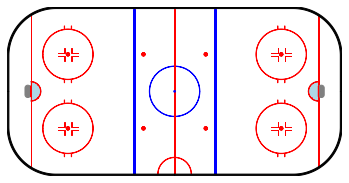

In [5]:
rink = IIHFRink(x_shift=100, y_shift=42.5)
ax = rink.draw()

Nice! Now let's add some data to the rink.

## Step 3: Add in event data

Let's look at the player positions for the first event for which we have player tracking:

In [6]:
event_data = matching_event_data.iloc[0]
event_data

game_date                                  8/2/2022
season_year                                    2021
team_name                  Olympic (Women) - Canada
opp_team_name       Olympic (Women) - United States
venue                                          away
period                                            1
clock_seconds                                   375
situation_type                               5 on 4
goals_for                                         0
goals_against                                     0
player_name                          Brianne Jenner
event                                          Play
event_successful                                  t
x_coord                                         185
y_coord                                           7
event_type                                   Direct
player_name_2                   Marie-Philip Poulin
x_coord_2                                     139.0
y_coord_2                                       5.0
event_detail

This is a successful direct pass from Brianne Jenner to Marie-Philip Poulin. It happens when there are 375 seconds on the clock (5:15) in the first period.

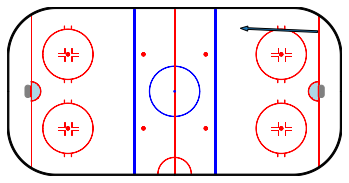

In [7]:
rink.arrow([event_data['x_coord']], [85 - event_data['y_coord']], 
           [event_data['x_coord_2']], [85 - event_data['y_coord_2']],
          width = 1, head_width = 3) 
            # Flip the y coordinates to match plotting coordinates
ax = rink.draw()

For that one second, let's find all the player locations. They will happen between frame indices 301 and 346 (30 frames in one second, add one extra half second to account for the uncertainty in event annotations).

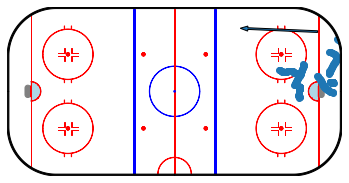

In [8]:
rink.arrow([event_data['x_coord']], [85 - event_data['y_coord']], 
           [event_data['x_coord_2']], [85 - event_data['y_coord_2']],
          width = 1, head_width = 3) 

pass_second_player_positions = pp_tracking.loc[(pp_tracking['frame_id'] >= 301) & (pp_tracking['frame_id'] < 346)]
rink.scatter(pass_second_player_positions['x_ft'], pass_second_player_positions['y_ft'])
ax = rink.draw()

A couple things to note:

- Each player's track consists of several observations over the 1.5 seconds. Let's find the mean coordinate to represent their position for the pass.
- None of the player tracks correspond exactly with the start of the pass. We can attribute this to error in the tracking data output. When we look at player jersey numbers, we can find out which track represents Jenner.
- The location of Poulin (the pass recipient) is not shown in the tracking data. This is probably because she is out of the camera's field of view for this second. We could advance through the tracking data frames until she is visible, but we'll just work with what we have

We can see Poulin's position appears at around frame index 376. Let's find the player position means and add in jersey number labels.

In [9]:
# Get roster information
roster_info = pd.read_csv('2022-02-08 Canada at USA/2022-02-08 Canada at USA roster.csv')

# Iterate over each player
unique_players = pass_second_player_positions['track_id'].unique()

# Collect mean player locations, jersey numbers and teams
all_players = []

for p in unique_players:
    player_locations = pass_second_player_positions.loc[pass_second_player_positions['track_id'] == p]
    mean_player_position = player_locations[['x_ft', 'y_ft']].mean().to_numpy()
    
    team_name = player_locations.iloc[0]['team_name']
    if team_name == 'Canada':
        team = 'away'
    else:
        team = 'home'
    
    jersey_number = player_locations.iloc[0]['jersey_number']
    
    # Having looked through the data, Brianne Jenner (#19) is misidentified as #11
    if jersey_number == 11 and team_name == 'Canada':
        jersey_number = 19
    
    player_name = roster_info.loc[(roster_info['team'] == team) & (roster_info['jn'] == jersey_number)]
    
    if len(player_name) == 0:
        # Jersey number was not found in roster
        continue # Skip
    
    all_players.append({
        'x_ft': mean_player_position[0],
        'y_ft': mean_player_position[1],
        'team_name': team_name,
        'jersey_number': jersey_number,
        'track_id': p,
        'player_name': player_name.iloc[0]['player']
    })

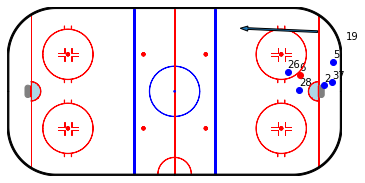

In [10]:
# From the previous plot
rink.arrow([event_data['x_coord']], [85 - event_data['y_coord']], 
           [event_data['x_coord_2']], [85 - event_data['y_coord_2']],
          width = 1, head_width = 3)

# New data
for p in all_players:
    rink.scatter(p['x_ft'], p['y_ft'], label = p['player_name'],
                color = 'red' if p['team_name'] == 'Canada' else 'blue')

ax = rink.draw()

for p in all_players:
    # Add jersey numbers
    ax.text(p['x_ft'] - 100, p['y_ft'] - 40, p['jersey_number'])

## Step 4: Interpret results

American penalty killers have the area behind the net and the slot covered. Brianne Jenner makes a smart pass by looking out to the blue line, which is wide open.

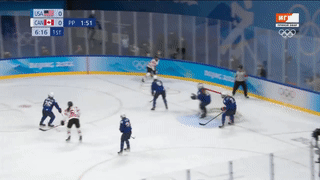